## Application of SentencePiece to the sentiment analysis of Naver moive review

## Imports

In [29]:
import os
import csv
import konlpy
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

## Data load

In [2]:
data = pd.read_table(os.getenv('HOME') + '/aiffel/sp_tokenizer/data/nsmc/ratings.txt')

data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


## Preprocessing

In [3]:
print(f'Data의 크기 : {len(data)}')

Data의 크기 : 200000


In [4]:
data[data.document.str.contains('nan', na = False)]

,id,document,label
125229,143967,이미 참여하셨습니다.qenansfyd123,0


In [5]:
data[data.duplicated(['document'])]

,id,document,label
187,3946738,굿,1
740,4217807,재밌다,1
1369,3044092,재밋다,1
1535,6924850,굿,1
1896,2417941,쵝오,1
...,...,...,...
199932,2334732,지루함...,0
199939,2105796,bad,0
199944,2100743,재미없다...,0
199946,735755,에혀,0


In [6]:
print(f'Id 컬럼의 Na 갯수 : { len(data[data.id.isnull()]) }')
print(f'Document 컬럼의 Na 갯수 : {len(data[data.document.isnull()])}')
print(f'Label 컬럼의 Na 갯수 : {len(data[data.label.isnull()])}')

data[data['document'].isnull()]

Id 컬럼의 Na 갯수 : 0
Document 컬럼의 Na 갯수 : 8
Label 컬럼의 Na 갯수 : 0


,id,document,label
46471,6369843,NaN,1
60735,511097,NaN,1
77665,2172111,NaN,1
84098,402110,NaN,1
127017,5942978,NaN,0
172375,5026896,NaN,0
173526,1034280,NaN,0
197279,1034283,NaN,0


In [7]:
data.dropna(how = 'any', inplace = True)
data.drop_duplicates('document', inplace = True)

In [8]:
data = data[~data.document.str.contains('nan')]

In [9]:
print(f'Preprocessed data의 크기 : {len(data)}')

Preprocessed data의 크기 : 194542


## EDA

In [10]:
naver_review = data['document']

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/tmp/ipykernel_92/2328176167.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_length = np.zeros((max_len), dtype=np.int)


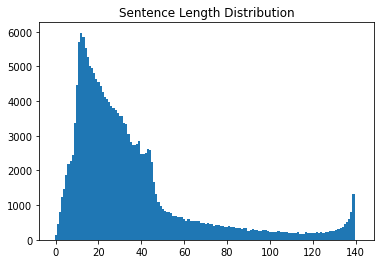

In [11]:
min_len = 999
max_len = 0
sum_len = 0

for sen in naver_review:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(naver_review))

train_length = np.zeros((max_len), dtype=np.int)

for sen in naver_review:   # 중복이 제거된 코퍼스 기준
    train_length[len(sen)-1] += 1

plt.bar(range(max_len), train_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [12]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(naver_review, 139)

어릴 때보고 커서 다시 봤는데. 진짜 잘 만든 영화였네. 웃음과 감동을 잘 이어 붙였고 정치에 대한 비판이랑 묘사도 굉장히 잘 표현했다. 흥행했었는지 기억은 안나지만 절대 낮은 평점의 영화가 아니라고 생각한다. 연기자들 연기하는 디테일만 봐도 따봉임
기억에 남는 장면이 많네요. 그네씬,할배야밤활키는씬,흰한복에화살피, 바다,배도 예뻐요. 또 이렇게 많은 명장면을 남겨주셔서 감사합니다. 보면서 밤볼라, 섬, 봄여름가을겨울그리고봄, 완전한 사육 등의 영화가 떠올랐습니다. 김기덕회고전 홀로 집에서 ㅋㅋ
배우들의 표정부터 다른 드라마.일반적인 한국드라마와는 매우 다르고 줄거리도 전혀 어색하지않고 사실적이라 딱딱한 느낌이 든다특히 추적자 이후 발전된 촌철살인은 일정 배경지식을 가지고있어야하고 1회만 놓혀도 갈피를 못잡아서 이런 시청률굴욕을 당하는거같다
무간도 3가 이해하기 어렵다 ..3번씩보고 그래도 이해가 안돼면 네이버 해석본봐라 .. 그럼 소름 쫙 돋을거다 니들머리로 해석할려닌까 무간도 3가 그냥 만들어진게 아니고 다 스토리가 이어져있다.. 내가볼땐 무간도 1,3이 진국이다. 니들머리로는 ㅉㅉ
시티헌터 다음으로 다시보기에 열중했던 드라마! 회마다 은근한 긴장감과 적절한 코미디를 넣어 무겁지만 가볍게 볼 수 있었던 최고의 드라마였다. 또 드라마답지 않게 스케일도 꽤 커서 보는 사람으로 하여금 박진감도 넘쳤다. 시즌2로 나오면 얼마나 좋을까?
두 형제가 겪는 일상에서의 고독과 좌절감을 그린 작품.. 정지된 카메라로 두 남자의 일상을 훔쳐보는 듯한 느낌을 주는데, 주로 롱샷으로 된 화면과 롱테이크기법으로 현대인이 겪는 고독과 소외감을 제대로 살리고 있다. 라스트씬의 롱테이크는 특히 압권..
개들에게서 느껴지는 동지애, 협동 정신, 강인한 생존력, 개들을 되찾기 위해 어떤 것도 아끼지 않고 모험을 감행하는 게리 세퍼드의 용기, 기꺼이 그들의 재회를 위해 몸을 아끼지 않고 모험에 동참한 동료 탐험대원들의 기지와 노고에 깊은 경의를 표한다.
아무리 생각해도 케이티 홈즈는 니콜키

/tmp/ipykernel_92/148705089.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_length = np.zeros((max_len), dtype=np.int)


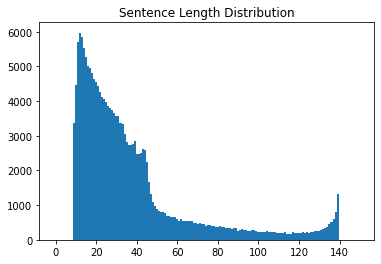

In [13]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_data = data[(data['document'].str.len() < max_len) & (data['document'].str.len() >= min_len)]

# 분포도를 다시 그려봅니다.
train_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_data['document']:
    train_length[len(sen)-1] += 1

plt.bar(range(max_len), train_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [14]:
print(f'Filtered data의 크기 : {len(filtered_data)}')

Filtered data의 크기 : 181695


## SentencePieceModel tokenizer

#### Training

In [15]:
temp_file = os.getenv('HOME') + '/aiffel/sp_tokenizer/data/nsmc/ratings.txt.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_data['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_unigram_8k --vocab_size={}'.format(temp_file, vocab_size)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bep_8k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/nsmc/ratings.txt.temp --model_prefix=kor_spm_unigram_8k --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/nsmc/ratings.txt.temp
  input_format: 
  model_prefix: kor_spm_unigram_8k
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bo

In [16]:
!ls -l kor_spm_unigram_8k*
!ls -l kor_spm_bep_8k*

-rw-r--r-- 1 root root 374860 Jul 11 00:24 kor_spm_unigram_8k.model
-rw-r--r-- 1 root root 144321 Jul 11 00:24 kor_spm_unigram_8k.vocab
-rw-r--r-- 1 root root 370341 Jul 11 00:25 kor_spm_bep_8k.model
-rw-r--r-- 1 root root 115555 Jul 11 00:25 kor_spm_bep_8k.vocab


## Comparing vocab between unigram and bpe

In [17]:
unigram_vocab_list = pd.read_csv('kor_spm_unigram_8k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
unigram_vocab_list[:10]

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.32209
4,.,-3.48143
5,..,-4.39524
6,이,-4.40150
7,▁영화,-4.58411
8,...,-4.63875
9,의,-4.71148


In [18]:
unigram_vocab_list.sample(10)

,0,1
2831,▁안됨,-9.70546
2619,거라,-9.63074
702,▁초,-8.37019
4168,▁감히,-10.12360
3249,▁퇴,-9.85060
3178,자리,-9.82907
3915,만큼은,-10.04850
269,▁일,-7.61519
2528,에서도,-9.60267
4646,▁변화,-10.25990


In [19]:
bpe_vocab_list = pd.read_csv('kor_spm_bep_8k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
bpe_vocab_list[:10]

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,▁그,-6


In [20]:
bpe_vocab_list.sample(10)

,0,1
6199,▁홍상수,-6196
5960,보구,-5957
5218,▁줘야,-5215
2968,▁지구,-2965
1004,▁암,-1001
5529,▁이제는,-5526
7791,갚,-7788
1074,▁브,-1071
194,▁살,-191
4360,부를,-4357


In [21]:
def test_performance(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

unigram이 좀더 정확하게 tokeninzing 하는 걸 확인

In [22]:
print('kor_spm_unigram_8k')
test_performance(model='kor_spm_unigram_8k.model')

print('kor_spm_bep_8k')
test_performance(model='kor_spm_bep_8k.model')

kor_spm_unigram_8k
[1390, 10, 382, 15, 1303, 10, 129, 18, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
kor_spm_bep_8k
[4803, 869, 6549, 6298, 6317, 1370, 6395, 6288, 6286]
['▁아버', '지가', '방', '에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


In [23]:
def sp_tokenize(s, corpus, path):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open(path, 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

## BPE + LSTM

In [24]:
s = spm.SentencePieceProcessor()
s.Load('kor_spm_bep_8k.model')

tensor, word_index, index_word = sp_tokenize(s, filtered_data['document'], "./kor_spm_bep_8k.vocab")
print(tensor)

[[1744  161  227 ...    0    0    0]
 [ 740 6342 2188 ...    0    0    0]
 [3131  685  636 ...    0    0    0]
 ...
 [ 216 5321    4 ...    0    0    0]
 [  84 6433  157 ...    0    0    0]
 [ 339 6851 6424 ...    0    0    0]]


In [25]:
tensor.shape

(181695, 131)

## Modeling

In [30]:
vocab_size = 8000
word_vector_dim = 128

In [31]:
filtered_label = np.array(filtered_data['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [32]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128, return_sequences = True))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1024000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
dense (Dense)                (None, None, 1)           129       
Total params: 1,155,713
Trainable params: 1,155,713
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('bpe_best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [35]:
epochs = 5
batch_size = 64

lstm_history = model.fit(x_train,
                    y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (x_val,y_val),
                    callbacks = [early,check],
                    verbose = 1)

Epoch 1/5
1817/1817 [==============================] - 866s 475ms/step - loss: 0.5669 - accuracy: 0.7210 - val_loss: 0.5528 - val_accuracy: 0.7366

Epoch 00001: saving model to bpe_best_model_lstm.h5
Epoch 2/5
1817/1817 [==============================] - 864s 476ms/step - loss: 0.4819 - accuracy: 0.7800 - val_loss: 0.4976 - val_accuracy: 0.7800

Epoch 00002: saving model to bpe_best_model_lstm.h5
Epoch 3/5
1817/1817 [==============================] - 865s 476ms/step - loss: 0.3962 - accuracy: 0.8315 - val_loss: 0.3732 - val_accuracy: 0.8345

Epoch 00003: saving model to bpe_best_model_lstm.h5
Epoch 4/5
1817/1817 [==============================] - 864s 476ms/step - loss: 0.3304 - accuracy: 0.8578 - val_loss: 0.3535 - val_accuracy: 0.8430

Epoch 00004: saving model to bpe_best_model_lstm.h5
Epoch 5/5
1817/1817 [==============================] - 863s 475ms/step - loss: 0.2963 - accuracy: 0.8738 - val_loss: 0.3491 - val_accuracy: 0.8446

Epoch 00005: saving model to bpe_best_model_lstm.h5


In [36]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

909/909 - 85s - loss: 0.3535 - accuracy: 0.8446
[0.35345834493637085, 0.8445538282394409]


In [37]:
def visualize_train(train_history, param):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

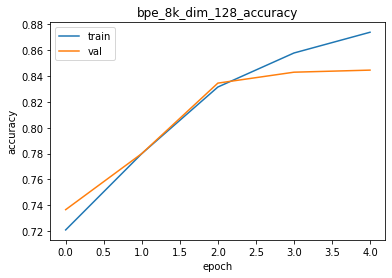

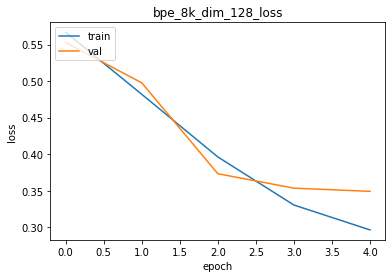

In [38]:
visualize_train(lstm_history, param = 'bpe_8k_dim_128')

## Unigram + LSTM

In [40]:
s = spm.SentencePieceProcessor()
s.Load('kor_spm_unigram_8k.model')

tensor, word_index, index_word = sp_tokenize(s, filtered_data['document'], "./kor_spm_unigram_8k.vocab")
print(tensor)

[[1640  156  232 ...    0    0    0]
 [1666   65   40 ...    0    0    0]
 [4055 1815  580 ...    0    0    0]
 ...
 [ 139 7044   32 ...    0    0    0]
 [  55  333 1025 ...    0    0    0]
 [1136 1831  375 ...    0    0    0]]


In [41]:
tensor.shape

(181695, 129)

## Traning and Test

In [42]:
vocab_size = 8000
word_vector_dim = 128

In [43]:
filtered_label = np.array(filtered_data['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [44]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128, return_sequences = True))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1024000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           129       
Total params: 1,155,713
Trainable params: 1,155,713
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('unigram_best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [47]:
epochs = 5
batch_size = 64

lstm_history = model.fit(x_train,
                    y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (x_val,y_val),
                    callbacks = [early,check],
                    verbose = 1)

Epoch 1/5
1817/1817 [==============================] - 840s 461ms/step - loss: 0.5735 - accuracy: 0.7083 - val_loss: 0.4713 - val_accuracy: 0.7880

Epoch 00001: saving model to unigram_best_model_lstm.h5
Epoch 2/5
1817/1817 [==============================] - 833s 458ms/step - loss: 0.5113 - accuracy: 0.7556 - val_loss: 0.3997 - val_accuracy: 0.8259

Epoch 00002: saving model to unigram_best_model_lstm.h5
Epoch 3/5
1817/1817 [==============================] - 833s 458ms/step - loss: 0.3511 - accuracy: 0.8477 - val_loss: 0.3496 - val_accuracy: 0.8456

Epoch 00003: saving model to unigram_best_model_lstm.h5
Epoch 4/5
1817/1817 [==============================] - 830s 457ms/step - loss: 0.3048 - accuracy: 0.8692 - val_loss: 0.3443 - val_accuracy: 0.8477

Epoch 00004: saving model to unigram_best_model_lstm.h5
Epoch 5/5
1817/1817 [==============================] - 833s 459ms/step - loss: 0.2718 - accuracy: 0.8825 - val_loss: 0.3574 - val_accuracy: 0.8478

Epoch 00005: saving model to unigram

In [48]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

909/909 - 84s - loss: 0.3549 - accuracy: 0.8459
[0.35487234592437744, 0.8458749055862427]


In [49]:
def visualize_train(train_history, param):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

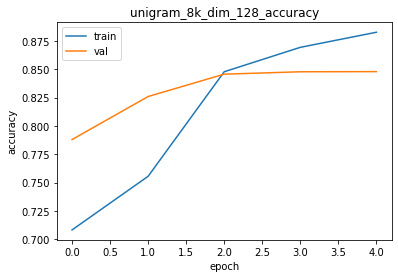

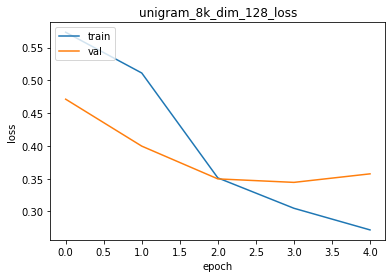

In [50]:
visualize_train(lstm_history, param = 'unigram_8k_dim_128')

## Mecab + LSTM

In [51]:
mecab = Mecab()

In [52]:
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_data['document']:
    mecab_corpus.append(mecab_split(kor))

In [53]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    '''
    위의 tokenizer 코드
    : corpus를 쪼개서 단어사전을 만듬
    '''

    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    '''
    위의 tensor 코드
    : corpus에 담긴 각 문장들을 단어사전으로 표현함
    '''
    return tensor, tokenizer

In [54]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 60326


In [55]:
mecab_tensor.shape

(181695, 116)

## Traning and Test

In [56]:
vocab_size = 60326 + 1
word_vector_dim = 128

In [57]:
filtered_label = np.array(filtered_data['label'])

x_train, x_val, y_train, y_val = train_test_split(mecab_tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [58]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128, return_sequences = True))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         7721856   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           129       
Total params: 7,853,569
Trainable params: 7,853,569
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('mecab_best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [61]:
epochs = 5
batch_size = 64

lstm_history = model.fit(x_train,
                    y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (x_val,y_val),
                    callbacks = [early,check],
                    verbose = 1)

Epoch 1/5
1817/1817 [==============================] - 970s 533ms/step - loss: 0.5637 - accuracy: 0.7266 - val_loss: 0.5156 - val_accuracy: 0.7821

Epoch 00001: saving model to mecab_best_model_lstm.h5
Epoch 2/5
1817/1817 [==============================] - 971s 535ms/step - loss: 0.5016 - accuracy: 0.7679 - val_loss: 0.4822 - val_accuracy: 0.7956

Epoch 00002: saving model to mecab_best_model_lstm.h5
Epoch 3/5
1817/1817 [==============================] - 971s 535ms/step - loss: 0.4736 - accuracy: 0.7633 - val_loss: 0.4540 - val_accuracy: 0.8096

Epoch 00003: saving model to mecab_best_model_lstm.h5
Epoch 4/5
1817/1817 [==============================] - 952s 524ms/step - loss: 0.3414 - accuracy: 0.8579 - val_loss: 0.3974 - val_accuracy: 0.8308

Epoch 00004: saving model to mecab_best_model_lstm.h5
Epoch 5/5
1817/1817 [==============================] - 955s 525ms/step - loss: 0.2677 - accuracy: 0.8914 - val_loss: 0.3897 - val_accuracy: 0.8367

Epoch 00005: saving model to mecab_best_mode

In [62]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

909/909 - 76s - loss: 0.3841 - accuracy: 0.8394
[0.3841182589530945, 0.8394126296043396]


In [63]:
def visualize_train(train_history, param):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

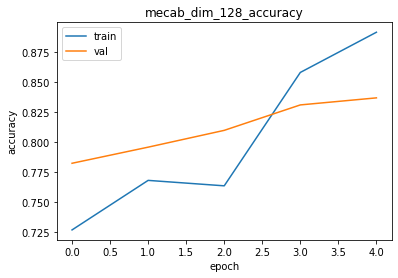

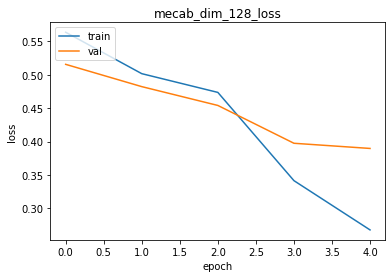

In [64]:
visualize_train(lstm_history, param = 'mecab_dim_128')

## Mecab_8k + LSTM

In [79]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, num_words=8000):   
    X_train = []
    for sentence in train_data['document']:
        temp_X = mecab.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

   
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
        
    return X_train, np.array(list(train_data['label'])), word_to_index
    
X_train, y_train, word_to_index = load_data(filtered_data)

In [80]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [91]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [92]:
mecab_corpus = get_decoded_sentences(X_train, index_to_word)

In [97]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

mecab_tensor.shape

MeCab Vocab Size: 7958


(181695, 115)

## Traning and Test

In [98]:
vocab_size = 8000
word_vector_dim = 128

In [99]:
filtered_label = np.array(filtered_data['label'])

x_train, x_val, y_train, y_val = train_test_split(mecab_tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [100]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128, return_sequences = True))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         1024000   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           129       
Total params: 1,155,713
Trainable params: 1,155,713
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [102]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('mecab_best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [103]:
epochs = 5
batch_size = 64

lstm_history = model.fit(x_train,
                    y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (x_val,y_val),
                    callbacks = [early,check],
                    verbose = 1)

Epoch 1/5
1817/1817 [==============================] - 756s 415ms/step - loss: 0.5623 - accuracy: 0.7183 - val_loss: 0.6029 - val_accuracy: 0.7587

Epoch 00001: saving model to mecab_best_model_lstm.h5
Epoch 2/5
1817/1817 [==============================] - 744s 409ms/step - loss: 0.5067 - accuracy: 0.7617 - val_loss: 0.4106 - val_accuracy: 0.8092

Epoch 00002: saving model to mecab_best_model_lstm.h5
Epoch 3/5
1817/1817 [==============================] - 743s 409ms/step - loss: 0.3751 - accuracy: 0.8313 - val_loss: 0.3749 - val_accuracy: 0.8282

Epoch 00003: saving model to mecab_best_model_lstm.h5
Epoch 4/5
1817/1817 [==============================] - 752s 414ms/step - loss: 0.3302 - accuracy: 0.8531 - val_loss: 0.3677 - val_accuracy: 0.8349

Epoch 00004: saving model to mecab_best_model_lstm.h5
Epoch 5/5
1817/1817 [==============================] - 768s 423ms/step - loss: 0.3013 - accuracy: 0.8662 - val_loss: 0.3729 - val_accuracy: 0.8320

Epoch 00005: saving model to mecab_best_mode

In [104]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

909/909 - 76s - loss: 0.3719 - accuracy: 0.8326
[0.3719397485256195, 0.8325744867324829]


In [105]:
def visualize_train(train_history, param):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

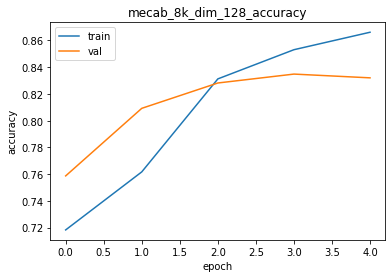

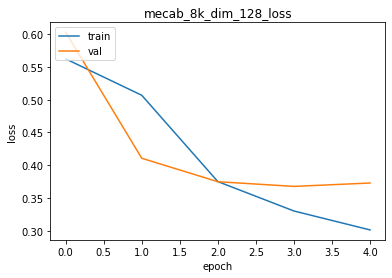

In [107]:
visualize_train(lstm_history, param = 'mecab_8k_dim_128')

## Discussion

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?  
 - 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?  
 - **EDA를 통해 문장 길이를 확인했으며, 전처리 이후에 SentencePiece를 적용했다.**  
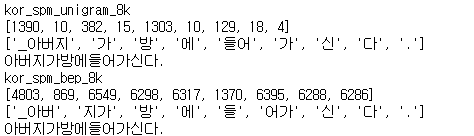
**Unigram 방식의 토큰화 결과가 좀 더 합리적인 것을 확인 했다.**  
 
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?  
 - **SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.**
| BPE | Unigram |
| --- | --- |
| 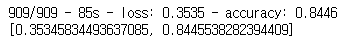 | 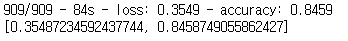 |
 - **BPE, Unigram에서 모두 80%이상의 accuracy를 확인했다.**  
 
 
3. SentencePiece의 성능을 다각도로 비교분석하였는가?  
 - SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.
 - **SentencePiece_BPE의 accuracy|loss가 가장 안정적으로 수렴하였으며, SentencePiece_Unigram의 accuracy|loss가 가장 우수했다.**  
 - **또한, Mecab을 사용해서 단어를 모두 사용하거나(Mecab_total), 8000개만 사용했을 때(Mecab_8k) 모두 test 정확도가 83%가량으로, SentencePiece 만큼의 performance를 보여주었다.**

## Reference

1. https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-02%5DSentencePiece.ipynb
2. https://koreascience.kr/article/CFKO202030060673825.pdf